In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(0)

# Regression

I am going to use a regression model where the y-values are defined by a property of the channel (in an MD simulation) which is indicative of the "openness" of the chanel and the X-values are defined by properties of the membrane surrounding the channel. The data is stored in two files: "data.dat" contains the membrane data and "hbond.dat" contains the channel data. The files both contain completely numeric data and is not missing any values.

# Load the X data as a Numpy array

The data (in the file) is stored as:
t_s1 t_s2 t_s3 c_s1 c_s2 c_s3 

t_s1: thickness of membrane in first shell

c_u_s1: composition in first shell

In [3]:
X = np.loadtxt('./data.dat')
X_names = ['t_s1','t_s2','t_s3','c_s1','c_s2','c_s3']
np.corrcoef(X, rowvar=False)

array([[ 1.        ,  0.3984287 ,  0.04787792, -0.21490411, -0.08362316,
         0.08336492],
       [ 0.3984287 ,  1.        ,  0.36774468, -0.06815592, -0.1322724 ,
         0.01992204],
       [ 0.04787792,  0.36774468,  1.        ,  0.12225909, -0.01820837,
        -0.06974861],
       [-0.21490411, -0.06815592,  0.12225909,  1.        , -0.22026457,
        -0.21450062],
       [-0.08362316, -0.1322724 , -0.01820837, -0.22026457,  1.        ,
        -0.37203631],
       [ 0.08336492,  0.01992204, -0.06974861, -0.21450062, -0.37203631,
         1.        ]])

# Load the y values as a Numpy array

This data (in the file) is the length of the 6 Hydrogen bonds. The sum of these bond lengths are used as y-values.

In [4]:
y =  np.loadtxt('./hbond.dat')
y = np.sum(y, axis = 1)

# Split the data into training and test sets (with an 70/30 split)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create SVM Regressor

In [5]:
reg = SVR(gamma=10)
reg.fit(X_train, y_train)
print("Train Score: %f" % reg.score(X_train, y_train))
print("Test Score: %f" % reg.score(X_test, y_test))
print("Train MSE: %f" % mean_squared_error(y_train, reg.predict(X_train)))
print("Test MSE: %f" % mean_squared_error(y_test, reg.predict(X_test)))

Train Score: 0.951865
Test Score: 0.635730
Train MSE: 0.012207
Test MSE: 0.092020


This is overfitting, lets try decreasing gamma.

In [6]:
reg = SVR(gamma=1)
reg.fit(X_train, y_train)
print("Train Score: %f" % reg.score(X_train, y_train))
print("Test Score: %f" % reg.score(X_test, y_test))
print("Train MSE: %f" % mean_squared_error(y_train, reg.predict(X_train)))
print("Test MSE: %f" % mean_squared_error(y_test, reg.predict(X_test)))

Train Score: 0.379482
Test Score: 0.133528
Train MSE: 0.157358
Test MSE: 0.218884


# Create Random Forest Regressor

In [7]:
params = {
    "n_estimators": [10, 50, 100, 500],
    "max_depth": [5, 10, 50],
    "bootstrap": [True, False]
}
RS = RandomizedSearchCV(RandomForestRegressor(bootstrap=True, random_state=0), params, random_state=0)
model = RS.fit(X_train, y_train)
model.best_params_

{'n_estimators': 500, 'max_depth': 50, 'bootstrap': True}

In [8]:
reg = RandomForestRegressor(n_estimators=500, max_depth=50, bootstrap=True, random_state=0)
reg.fit(X_train,y_train)
print("Train Score: %f" % reg.score(X_train, y_train))
print("Test Score: %f" % reg.score(X_test, y_test))
print("Train MSE: %f" % mean_squared_error(y_train, reg.predict(X_train)))
print("Test MSE: %f" % mean_squared_error(y_test, reg.predict(X_test)))

Train Score: 0.946349
Test Score: 0.615002
Train MSE: 0.013605
Test MSE: 0.097257


This is overfitting, let's try decreasing the number of trees.

In [9]:
reg = RandomForestRegressor(n_estimators=100, max_depth=50, bootstrap=True, random_state=0)
reg.fit(X_train,y_train)
print("Train Score: %f" % reg.score(X_train, y_train))
print("Test Score: %f" % reg.score(X_test, y_test))
print("Train MSE: %f" % mean_squared_error(y_train, reg.predict(X_train)))
print("Test MSE: %f" % mean_squared_error(y_test, reg.predict(X_test)))

Train Score: 0.943612
Test Score: 0.611759
Train MSE: 0.014299
Test MSE: 0.098076


Decreasing from 500 trees to 100 trees doesn't lose much accuracy, but it is still over fitting. Let's look at a range.

In [10]:
MSE_train = []
MSE_test = []
R2_train = []
R2_test = []

reg = RandomForestRegressor(n_estimators=1, max_depth=50, bootstrap=True, random_state=0)

for i in range(1, 100, 10):
    reg.fit(X_train,y_train)
    R2_train.append(reg.score(X_train, y_train))
    R2_test.append(reg.score(X_test, y_test))
    MSE_train.append(mean_squared_error(y_train, reg.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, reg.predict(X_test)))
    reg.n_estimators += 10

<function matplotlib.pyplot.show(close=None, block=None)>

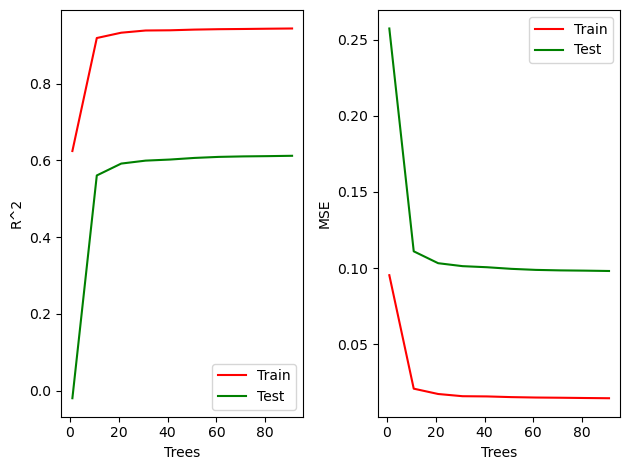

In [11]:
plt.subplot(1,2,1)
plt.plot(range(1,100,10), R2_train, '-r', label='Train')
plt.plot(range(1,100,10), R2_test,'-g', label='Test')
plt.xlabel('Trees')
plt.ylabel('R^2')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,100,10), MSE_train, '-r', label='Train')
plt.plot(range(1,100,10), MSE_test, '-g', label='Test')
plt.xlabel('Trees')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show

Decrease the number of trees speeds up the model without changing the score much. Moving forward 30 trees will be used, since it is in the plateau.

This is still overfitting, let's try reducing the max_depth. The max_depth controls the growth of the trees, reducing the complexity of the model.

In [12]:
reg = RandomForestRegressor(n_estimators=30, max_depth=40, bootstrap=True, random_state=0)
reg.fit(X_train,y_train)
print("Train Score: %f" % reg.score(X_train, y_train))
print("Test Score: %f" % reg.score(X_test, y_test))
print("Train MSE: %f" % mean_squared_error(y_train, reg.predict(X_train)))
print("Test MSE: %f" % mean_squared_error(y_test, reg.predict(X_test)))

Train Score: 0.927295
Test Score: 0.590026
Train MSE: 0.018437
Test MSE: 0.103566


Decreasing from 50 to 40 doesn't change the score much, let's look at a range and see when the overfitting stops.

In [13]:
MSE_train = []
MSE_test = []
R2_train = []
R2_test = []

reg = RandomForestRegressor(n_estimators=30, max_depth=1, bootstrap=True, random_state=0)

for i in range(1, 50):
    reg.fit(X_train,y_train)
    R2_train.append(reg.score(X_train, y_train))
    R2_test.append(reg.score(X_test, y_test))
    MSE_train.append(mean_squared_error(y_train, reg.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, reg.predict(X_test)))
    reg.max_depth += 1

<function matplotlib.pyplot.show(close=None, block=None)>

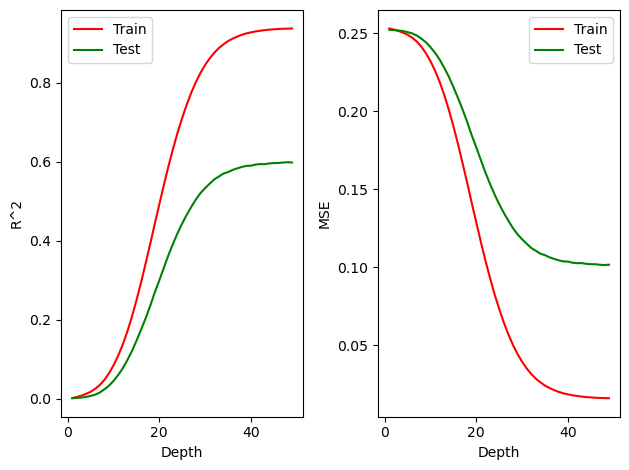

In [14]:
plt.subplot(1,2,1)
plt.plot(range(1,50), R2_train, '-r', label='Train')
plt.plot(range(1,50), R2_test,'-g', label='Test')
plt.xlabel('Depth')
plt.ylabel('R^2')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,50), MSE_train, '-r', label='Train')
plt.plot(range(1,50), MSE_test, '-g', label='Test')
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show

This impacts the overfitting, however it does not overcome the problem. 

Now let's try tuning the minimum samples per leaf. This essentially smooths the function.

In [15]:
reg = RandomForestRegressor(n_estimators=30, max_depth=21, min_samples_leaf=2, bootstrap=True, random_state=0)
reg.fit(X_train,y_train)
print("Train Score: %f" % reg.score(X_train, y_train))
print("Test Score: %f" % reg.score(X_test, y_test))
print("Train MSE: %f" % mean_squared_error(y_train, reg.predict(X_train)))
print("Test MSE: %f" % mean_squared_error(y_test, reg.predict(X_test)))

Train Score: 0.523821
Test Score: 0.313686
Train MSE: 0.120755
Test MSE: 0.173374


In [16]:
MSE_train = []
MSE_test = []
R2_train = []
R2_test = []

reg = RandomForestRegressor(n_estimators=30, max_depth=21, min_samples_leaf=1, bootstrap=True, random_state=0)

for i in range(1, 15):
    reg.fit(X_train,y_train)
    R2_train.append(reg.score(X_train, y_train))
    R2_test.append(reg.score(X_test, y_test))
    MSE_train.append(mean_squared_error(y_train, reg.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, reg.predict(X_test)))
    reg.min_samples_leaf += 1

<function matplotlib.pyplot.show(close=None, block=None)>

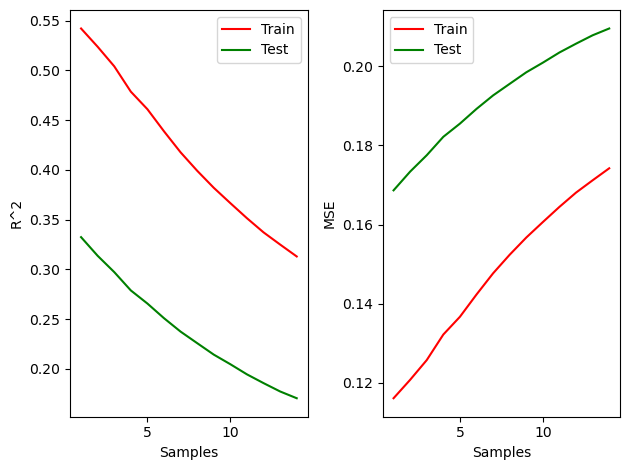

In [17]:
plt.subplot(1,2,1)
plt.plot(range(1,15), R2_train, '-r', label='Train')
plt.plot(range(1,15), R2_test,'-g', label='Test')
plt.xlabel('Samples')
plt.ylabel('R^2')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,15), MSE_train, '-r', label='Train')
plt.plot(range(1,15), MSE_test, '-g', label='Test')
plt.xlabel('Samples')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show

This doesn't impact the overfitting. Essentially the model will always overfit, which is a sign of not enough data.

Even though I failed to find a good fit, an interesting property of the RF regression is the feature importance.

I know that this is still overfitting, but I am going to look at the feature importance anyway for completeness. I know that I can't use these feature importances to mean anything, but it is a nice property of the RF Regressor and part of the reason for this choice of model. The hyperparameters used are: # of trees = 30, max_depth = 21, min_samples_leaf = 3, this is the midpoint of the array tried.

In [6]:
reg = RandomForestRegressor(n_estimators=30, max_depth=21, min_samples_leaf=3, bootstrap=True, random_state=0)
reg.fit(X_train,y_train)
print("Train Score: %f" % reg.score(X_train, y_train))
print("Test Score: %f" % reg.score(X_test, y_test))
print("Train MSE: %f" % mean_squared_error(y_train, reg.predict(X_train)))
print("Test MSE: %f" % mean_squared_error(y_test, reg.predict(X_test)))

Train Score: 0.504173
Test Score: 0.297314
Train MSE: 0.125738
Test MSE: 0.177509


<BarContainer object of 6 artists>

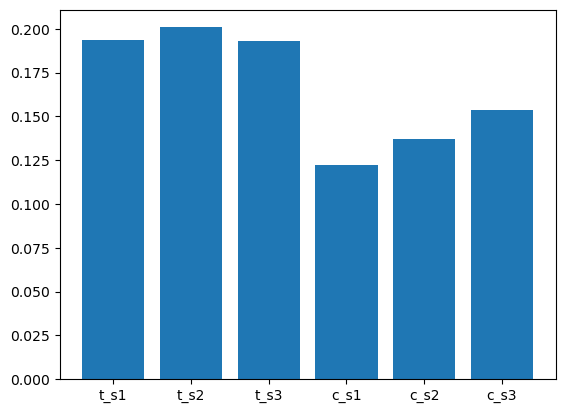

In [7]:
reg.feature_importances_
plt.bar(X_names, reg.feature_importances_)

# References

Code was adapted from these sources:

[SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), [CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools and Techniques to Build Intelligent Systems by Aurelien Geron: Chapters 2 and 4